# Demo Colab for Team C1

Intro goes here lol

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Data loading & preprocessing

The data acquisition process is omitted for brevity. Instead, 100 (for now) images are used as a sample.

In [20]:
!unzip -q samples.zip
!rm -rf __MACOSX/

In [19]:
# !rm -rf sample* test/ train

### Load training data

In [21]:
transform = transforms.Compose([
                                  # transforms.Resize(255),
                                  # transforms.CenterCrop(224),
                                  transforms.ToTensor()
                                 ])
dataset = torchvision.datasets.ImageFolder("./train", transform=transform)
print(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


### Load testing data

In [22]:
transform = transforms.Compose([
                                  # transforms.Resize(255),
                                  # transforms.CenterCrop(224),
                                  transforms.ToTensor()
                                 ])
testing_data = torchvision.datasets.ImageFolder("./test", transform=transform)
print(testing_data)
test_data_loader = torch.utils.data.DataLoader(testing_data, batch_size=10)

Dataset ImageFolder
    Number of datapoints: 102
    Root location: ./test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


## Basic data exploration

In [ ]:
dataset.classes

['0', '1']

torch.Size([10, 3, 96, 96])
---
label: tensor(1)


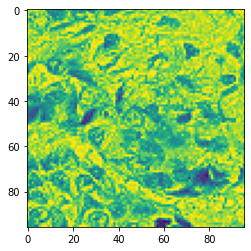

In [23]:
data_iter = iter(dataloader)

images, labels = next(data_iter)
print(images.shape)
print("---")
print("label:", labels[0])
plt.imshow(images[0][0]) # first image, first channel (R)

## Model initialisation

In [24]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(7056, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        # softmax at the end
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

net = Net()
print(net)

params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=7056, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)
10
torch.Size([6, 3, 5, 5])


## Loss Function & Optimiser

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training

In [26]:
PRINT_CYCLE = 3

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % PRINT_CYCLE == (PRINT_CYCLE-1):    # print every few mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / PRINT_CYCLE:.3f}')
            running_loss = 0.0


[1,     3] loss: 0.690
[1,     6] loss: 0.694
[1,     9] loss: 0.691
[1,    12] loss: 0.694
[1,    15] loss: 0.698
[1,    18] loss: 0.694
[2,     3] loss: 0.694
[2,     6] loss: 0.693
[2,     9] loss: 0.693
[2,    12] loss: 0.694
[2,    15] loss: 0.693
[2,    18] loss: 0.693
[3,     3] loss: 0.693
[3,     6] loss: 0.692
[3,     9] loss: 0.693
[3,    12] loss: 0.693
[3,    15] loss: 0.693
[3,    18] loss: 0.692
[4,     3] loss: 0.692
[4,     6] loss: 0.692
[4,     9] loss: 0.694
[4,    12] loss: 0.692
[4,    15] loss: 0.692
[4,    18] loss: 0.693
[5,     3] loss: 0.692
[5,     6] loss: 0.693
[5,     9] loss: 0.693
[5,    12] loss: 0.691
[5,    15] loss: 0.691
[5,    18] loss: 0.693


## Testing

In [27]:
input = torch.randn(1, 3, 96, 96)
out = net(input)
print(out)

tensor([[0.5018, 0.4982]], grad_fn=<SoftmaxBackward0>)


In [28]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        print(f"{predicted.numpy()} vs {labels.numpy()}")
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the training images: {100 * correct / total} %')

[0 0 0 0 0 0 0 0 0 0] vs [0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0] vs [0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0] vs [0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0] vs [0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0] vs [0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0] vs [0 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0] vs [1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 1 1 0 0 0] vs [1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0] vs [1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 1 0 0 0] vs [1 1 1 1 1 1 1 1 1 1]
[0 0] vs [1 1]
Accuracy of the network on the training images: 51.96078431372549 %


## Evaluation

## Analysis